## Dataset [Seizure recognition](https://www.kaggle.com/harunshimanto/epileptic-seizure-recognition) was downloaded from Kaggle. More details can be found at: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition), the original data source.
### The dataset is preprocessed and ready to use
- Brain EEG recordings from 500 subjects 
- Each subject was recorded for ~23 seconds at ~178Hz acquisition rate

### Samples are in one-second chuck (178 timesteps)
- samples = 11500 (23 second * 500 subjects)
- Tx=178 timesteps at 178Hz (each sample is a 1 second EEG recording)
- feature = 1 dim vector (EEG readout number, in micro-volt)

### Label y (categorical: 1, 2, 3, 4, 5)
- shape (sample, 1), last column of the CSV
- 5 - Eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open
- 4 - Eyes closed, means when they were recording the EEG signal the patient had their eyes closed
- 3 - They identify where the region of the tumor was in the brain and recording the EEG activity from healthy area
- 2 - They recorder the EEG from the area where the tumor was located
- 1 - Recording of seizure activity

### Model goal: differentiate EEG recordings of healthy subjects from that of epileptic and brain tumor subjects
- it is possible to do a 5 dimension prediction, but I was unable to get accuracy over 90%; mainly the model has a hard time on label group 2 vs 3, and on group 4 and 5
- I use raw numbers to train the model. It is possible and makes biological sense to use differnece at t and t+1 timesteps. However, I got better performance from the former. Also, Batch norm has little effect on performance. 

Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, Phys. Rev. E, 64, 061907

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.layers import Dense, Activation, CuDNNLSTM #use LSTM if CuDNN not available
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [2]:
# run this if GPU version of tensorflow is installed. Check if GPU is found and used. 
gpu_name = tf.test.gpu_device_name()
if gpu_name != "/device:GPU:0":
    raise SystemError("GPU not found")
print(f"GPU found: {gpu_name}")

GPU found: /device:GPU:0


In [3]:
#read in dataset from csv
datafile = os.path.join("./dataset_kaggle/Epileptic Seizure Recognition.csv")
df = pd.read_csv(datafile, index_col=0)

# consolidate five groups into three: epileptic(y=1), tumor(y=2), healthy(y=3)
# there are 2300 samples in group 1, 4600 samples in group 2, and 4600 samples in group 3
df["y"] = df["y"].replace(3,2).replace(5,4).replace(4,3)
df.index.name = "sample id"
df.columns.name ="timepoints"
print(f"There are {len(df)} samples, each with 178 timestamps over 1 second (178Hz sampling rate)")
df.head() # a preview of the dataset

There are 11500 samples, each with 178 timestamps over 1 second (178Hz sampling rate)


timepoints,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
sample id,,,,,,,,,,,,,,,,,,,,,
X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,3
X15.V1.924,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,3
X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,3
X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,3


In [4]:
# split pandas dataframe to 90:10 for training and testing
np.random.seed(seed=0)
msk = np.random.rand(len(df)) < 0.9

# use raw numbers in voltage to train
train_X, train_y = df[msk].iloc[:,:-1], df[msk].iloc[:,-1]
test_X, test_y = df[~msk].iloc[:,:-1], df[~msk].iloc[:,-1]

# Alternatively use difference between timesteps to train
# train_X = df[msk].iloc[:,:-1].diff(axis=1).drop(columns="X1")
# train_y = df[msk].iloc[:,-1]
# test_X = df[~msk].iloc[:,:-1].diff(axis=1).drop(columns="X1")
# test_y = df[~msk].iloc[:,-1]

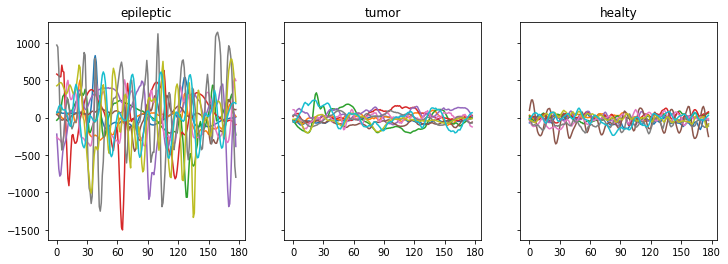

In [5]:
# Ramdonly show 10 samples from each group
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True)

labels = ["epileptic", "tumor", "healty"]

for i, ax in zip(range(3), axes.flat):
    ax.set_title(labels[i])
    ax.set(xticks=np.arange(0,185,30))
    samples = df[df.iloc[:,-1]==(i+1)].sample(10)
    for j in range(len(samples)):
        ax.plot(np.arange(0,178,1), samples.iloc[j, :-1])


In [6]:
# m is number of samples, Tx is number of timesteps, feature dim. is 1 (single number in voltage)
m_train, Tx = train_X.shape
m_test = test_X.shape[0]

# convert pandas dataframe to numpy array and reshape them. 
# Keras does not take pandas dataframe
train_X = train_X.values.reshape(m_train, Tx, 1)
train_y = train_y.values.reshape(m_train, 1)
test_X = test_X.values.reshape(m_test, Tx, 1)
test_y = test_y.values.reshape(m_test, 1)

# convert label y to one-hot vector
output_class = 3 # there are 3 possible predictions
train_y = train_y - 1
train_y = np.eye(output_class)[train_y.reshape(-1)]
test_y = test_y - 1
test_y = np.eye(output_class)[test_y.reshape(-1)]

In [7]:
def simple_LSTM_model(Tx):
    
    Inputs = Input(shape=(Tx,1), dtype="float32") 
#     X = BatchNormalization()(Inputs)
    
    X = CuDNNLSTM(256, return_sequences=True)(Inputs)
#     X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    
    X = CuDNNLSTM(256, return_sequences=True)(X)
#     X = BatchNormalization()(X)
    X = Dropout(0.5)(X)

    X = CuDNNLSTM(256)(X)
#     X = BatchNormalization()(X)
    X = Dropout(0.5)(X)

    X = Dense(128, activation="relu")(X)
    X = Dropout(0.5)(X)
    X = Dense(3)(X)
    out = Activation("softmax")(X)
    
    model = Model(inputs=Inputs, outputs=out)

    return model

Tx = train_X.shape[1]
model = simple_LSTM_model(Tx)
model.summary()

W0901 22:36:55.889519 12728 deprecation.py:506] From C:\Users\josta\Anaconda3\envs\ML\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 178, 1)]          0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 178, 256)          265216    
_________________________________________________________________
dropout (Dropout)            (None, 178, 256)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 178, 256)          526336    
_________________________________________________________________
dropout_1 (Dropout)          (None, 178, 256)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 256)               526336    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0     

In [8]:
opt = Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), batch_size=32, epochs=15)

Train on 10353 samples, validate on 1147 samples
Epoch 1/15
10353/10353 [==============================] - 13s 1ms/sample - loss: 0.6002 - acc: 0.7481 - val_loss: 0.4164 - val_acc: 0.8544
Epoch 2/15
10353/10353 [==============================] - 12s 1ms/sample - loss: 0.3712 - acc: 0.8680 - val_loss: 0.2956 - val_acc: 0.9041
Epoch 3/15
10353/10353 [==============================] - 11s 1ms/sample - loss: 0.3230 - acc: 0.8860 - val_loss: 0.2962 - val_acc: 0.9067
Epoch 4/15
10353/10353 [==============================] - 11s 1ms/sample - loss: 0.2603 - acc: 0.9051 - val_loss: 0.2697 - val_acc: 0.9015
Epoch 5/15
10353/10353 [==============================] - 11s 1ms/sample - loss: 0.2616 - acc: 0.9117 - val_loss: 0.2145 - val_acc: 0.9241
Epoch 6/15
10353/10353 [==============================] - 11s 1ms/sample - loss: 0.2331 - acc: 0.9159 - val_loss: 0.2102 - val_acc: 0.9241
Epoch 7/15
10353/10353 [==============================] - 11s 1ms/sample - loss: 0.2337 - acc: 0.9183 - val_loss: 0.2

1147/1147 [==============================] - 1s 491us/sample - loss: 0.2116 - acc: 0.9285
Loss = 0.212; Accuracy = 0.929


C:\Users\josta\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


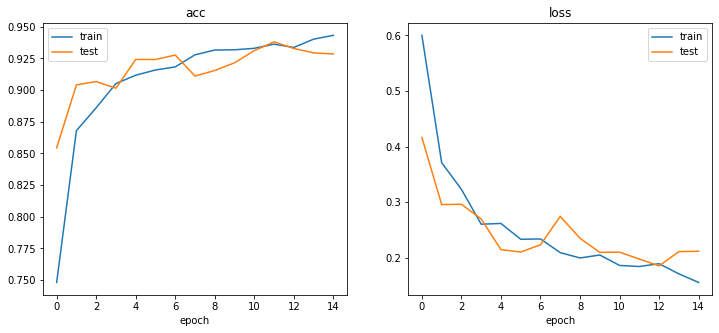

In [9]:
loss, acc = model.evaluate(test_X, test_y)
print(f"Loss = {loss:.3f}; Accuracy = {acc:.3f}")

# visualize accuracy over training epochs
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

for metric, ax in zip(["acc", "loss"], axes.flat):
    ax.plot(history.history[metric], label="train")
    ax.plot(history.history[f"val_{metric}"], label="test")
    ax.set(xlabel="epoch", title=metric)
    ax.legend()

fig.show()

In [10]:
pred = model.predict(test_X)
err = []
for m in range(test_X.shape[0]):
    prediction = np.argmax(pred[m])
    label = np.argmax(test_y[m])
    if prediction != label:
        err.append((prediction, label))
print(f"There are {len(err)} samples got wrong prediction")

There are 82 samples got wrong prediction


In [11]:
# Breaking down errors 
pred = model.predict(test_X)
err = []
for m in range(test_X.shape[0]):
    prediction = np.argmax(pred[m])
    label = np.argmax(test_y[m])
    if prediction != label:
        err.append((prediction, label))
print(f"{len(err)} samples were wrongly predicted")

model_pred, true_label = np.argmax(pred, axis=1)+1, np.argmax(test_y, axis=1)+1
err_ana = pd.DataFrame({"model_pred":model_pred, "true_label":true_label})

df_error = pd.DataFrame({
    "label_1": err_ana[err_ana["true_label"]==1]["model_pred"].value_counts(),
    "label_2": err_ana[err_ana["true_label"]==2]["model_pred"].value_counts(),
    "label_3": err_ana[err_ana["true_label"]==3]["model_pred"].value_counts(),
#     "label_4": err_ana[err_ana["true_label"]==4]["model_pred"].value_counts(),
#     "label_5": err_ana[err_ana["true_label"]==5]["model_pred"].value_counts()
})

df_error["total_pred"] = df_error.sum(axis=1)
df_error = df_error.append((df_error.sum(axis=0)), ignore_index=True)
df_error["pred"] = ["pred_1", "pred_2", "pred_3", "total_label"]
df_error.set_index("pred", inplace=True)
df_error

82 samples were wrongly predicted


,label_1,label_2,label_3,total_pred
pred,,,,
pred_1,226.0,16.0,NaN,242.0
pred_2,9.0,394.0,10.0,413.0
pred_3,3.0,44.0,445.0,492.0
total_label,238.0,454.0,455.0,1147.0


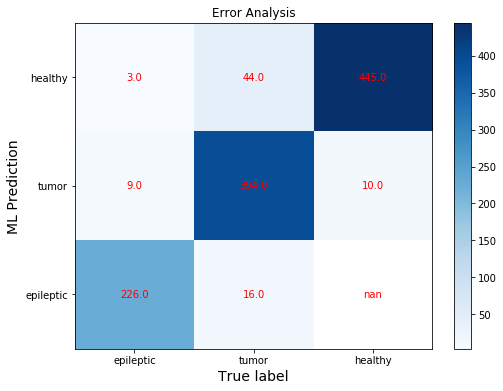

In [12]:
# Visualize error distribution

heat_array = df_error.iloc[:-1, :-1].values

_, hmap = plt.subplots(figsize=(8,6))

im = hmap.imshow(heat_array, cmap="Blues", aspect="auto")
plt.colorbar(im, ax=hmap)
hmap.set(xticks=np.arange(0,3,1), yticks=np.arange(0,3,1),
         xlim=(-0.5,2.5), ylim=(-0.5,2.5), 
         xticklabels=["epileptic", "tumor", "healthy"],
         yticklabels=["epileptic", "tumor", "healthy"],
         title="Error Analysis"
        )

hmap.set_xlabel("True label", size=14)
hmap.set_ylabel("ML Prediction", size=14)
    
for i in range(3):
    for j in range(3):
        hmap.text(j, i, heat_array[i, j],
                       ha="center", va="center", color="r")

In [13]:
# model.save("./saved_models/simple_LSTM_seizure_recognition.h5")